<a href="https://colab.research.google.com/github/MuftiqurBista1111/Unisnacks_Data_Forecasting/blob/main/LSTM_13_5_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [180]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from datetime import date
import datetime
from dateutil.relativedelta import relativedelta
from datetime import timedelta
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
# import pmdarima as pm
import itertools
import math
import matplotlib.pyplot as plt


from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [181]:
data = pd.read_csv("/content/Sales Order Custom Search Bista Results - 747 - Revised.csv", parse_dates=True)


In [182]:

data_new = data.loc[:,['Customer Name','Date','Quantity','Item : Internal ID']]
data_new.rename(columns={'Item : Internal ID': 'Product_Id', 'Name':'Customer_Name'}, inplace=True)
# Drop rows with NaN values in Product_Id column
data_new.dropna(subset=['Product_Id'], inplace=True)

result = data_new.groupby(['Customer Name', 'Product_Id', 'Date', 'Quantity']).size().reset_index()

In [183]:
# Define your function to load and preprocess data
def preprocess_data(file_path):
    # Load data
    data = pd.read_csv(file_path, parse_dates=True)

    # Select relevant columns and rename
    data_new = data.loc[:,['Customer Name','Date','Quantity','Item : Internal ID']]
    data_new.rename(columns={'Item : Internal ID': 'Product_Id', 'Customer Name':'Customer_Name'}, inplace=True)

    # Drop rows with NaN values in Product_Id column
    data_new.dropna(subset=['Product_Id'], inplace=True)

    # Group by Customer Name, Product_Id, Date, and Quantity
    result = data_new.groupby(['Customer_Name', 'Product_Id', 'Date', 'Quantity']).size().reset_index()

    return result

In [184]:
def get_customer_product_data(data):
    # Initialize an empty dictionary to store customer-wise dataframes
    customer_dataframes = {}

    # Initialize empty lists to store customer names and product IDs with more than 15 entries
    selected_customers = []
    selected_products = []

    # Iterate over unique customers
    unique_customers = data['Customer_Name'].unique()
    for customer in unique_customers:
        # Filter data for the current customer
        customer_data = data[data['Customer_Name'] == customer]

        # Iterate over unique products purchased by the customer
        unique_products = customer_data['Product_Id'].unique()
        for product in unique_products:
            # Filter data for the current product
            product_data = customer_data[customer_data['Product_Id'] == product]

            # Check if the number of entries for the product is more than 15
            if len(product_data) > 15:
                # Extract date and quantity information for the product
                product_sales_data = product_data[['Date', 'Quantity']]

                # Add the customer and product to selected lists
                selected_customers.append(customer)
                selected_products.append(product)

                # Add the product sales data to the dictionary using customer and product as keys
                customer_dataframes[(customer, product)] = product_sales_data

    return selected_customers, selected_products, customer_dataframes


In [185]:
# Load and preprocess your data (replace 'file_path' with your actual file path)
file_path = "/content/Sales Order Custom Search Bista Results - 747 - Revised.csv"
result = preprocess_data(file_path)

# Get selected customers and products
selected_customers, selected_products, customer_product_data = get_customer_product_data(result)

# Display selected customers and products
print("Customers and Product IDs with total sales quantity more than 15:")
for customer, product in zip(selected_customers, selected_products):
    print(f"Customer: {customer}, Product: {product}")

Customers and Product IDs with total sales quantity more than 15:
Customer: ABX001 Matthews Foods- Aberdeen, Product: 423.0
Customer: ABX001 Matthews Foods- Aberdeen, Product: 424.0
Customer: ABX001 Matthews Foods- Aberdeen, Product: 442.0
Customer: ABX001 Matthews Foods- Aberdeen, Product: 443.0
Customer: ABX001 Matthews Foods- Aberdeen, Product: 444.0
Customer: ABX001 Matthews Foods- Aberdeen, Product: 445.0
Customer: ABX001 Matthews Foods- Aberdeen, Product: 460.0
Customer: ABX001 Matthews Foods- Aberdeen, Product: 469.0
Customer: ABX001 Matthews Foods- Aberdeen, Product: 480.0
Customer: ABX001 Matthews Foods- Aberdeen, Product: 481.0
Customer: ABX001 Matthews Foods- Aberdeen, Product: 487.0
Customer: ABX001 Matthews Foods- Aberdeen, Product: 488.0
Customer: ABX001 Matthews Foods- Aberdeen, Product: 490.0
Customer: ABX001 Matthews Foods- Aberdeen, Product: 492.0
Customer: ABX001 Matthews Foods- Aberdeen, Product: 493.0
Customer: ABX001 Matthews Foods- Aberdeen, Product: 494.0
Custom

In [187]:
def get_customer_product_dataframe(customer, product, customer_product_data):
    return customer_product_data.get((customer, product), None)

# Example: Select a specific customer and product
selected_customer = "WXX018 Xingja Reunion Co. Ltd T/A Tianfu"
selected_product = 918.0

# Get date and quantity DataFrame for the selected customer and product
selected_dataframe = get_customer_product_dataframe(selected_customer, selected_product, customer_product_data)

# Update the 'Quantity' column of selected_dataframe to have all values as 1
selected_dataframe['Quantity'] = 1

# Print the DataFrame
if selected_dataframe is not None:
    print(f"\nDate and Quantity DataFrame for Customer: {selected_customer}, Product: {selected_product}:")
    print(selected_dataframe)
else:
    print(f"No data found for Customer: {selected_customer}, Product: {selected_product}")



Date and Quantity DataFrame for Customer: WXX018 Xingja Reunion Co. Ltd T/A Tianfu, Product: 918.0:
              Date  Quantity
382572  01/09/2020         1
382573  03/07/2021         1
382574  04/06/2021         1
382575  05/08/2022         1
382576  05/10/2021         1
382577  06/12/2020         1
382578  09/12/2022         1
382579  10/12/2019         1
382580  14/04/2021         1
382581  14/09/2020         1
382582  14/12/2021         1
382583  18/02/2022         1
382584  18/05/2021         1
382585  19/02/2021         1
382586  21/09/2022         1
382587  22/08/2021         1
382588  23/04/2021         1
382589  26/08/2022         1
382590  29/01/2020         1
382591  29/10/2019         1
382592  29/10/2021         1
382593  30/03/2022         1
382594  30/04/2022         1
382595  30/09/2020         1
382596  31/10/2022         1


In [188]:
import datetime
from dateutil.relativedelta import relativedelta

# Define the operation to create a DataFrame for 5 years data with all zeros
today = datetime.date.today()
end_date = today.replace(day=1) - datetime.timedelta(days=1)
start_date = end_date + relativedelta(years=-5)
date_range = pd.date_range(start=start_date, end=end_date, freq="Q")
new_df = pd.DataFrame({'Date': date_range.strftime('%d/%m/%Y'), 'Quantity': 0.00})

# Convert 'Date' column to object data type
new_df['Date'] = new_df['Date'].astype('object')

# Convert 'Quantity' column to float64 data type
new_df['Quantity'] = new_df['Quantity'].astype('float64')

# Print the new DataFrame
print("New DataFrame:")
print(new_df)


New DataFrame:
          Date  Quantity
0   30/06/2019       0.0
1   30/09/2019       0.0
2   31/12/2019       0.0
3   31/03/2020       0.0
4   30/06/2020       0.0
5   30/09/2020       0.0
6   31/12/2020       0.0
7   31/03/2021       0.0
8   30/06/2021       0.0
9   30/09/2021       0.0
10  31/12/2021       0.0
11  31/03/2022       0.0
12  30/06/2022       0.0
13  30/09/2022       0.0
14  31/12/2022       0.0
15  31/03/2023       0.0
16  30/06/2023       0.0
17  30/09/2023       0.0
18  31/12/2023       0.0
19  31/03/2024       0.0


In [189]:
# Merge new_df with selected_dataframe
merged_df = pd.concat([new_df, selected_dataframe], ignore_index=True)

# Convert 'Date' column to datetime format
merged_df['Date'] = pd.to_datetime(merged_df['Date'], format='%d/%m/%Y')

# Fill NaN values with 0.00 for Quantity
merged_df['Quantity'].fillna(0.00, inplace=True)

# Sort the DataFrame by the 'Date' column
merged_df = merged_df.sort_values(by='Date')

# Print the merged and sorted DataFrame
print("Merged and Sorted DataFrame:")
print(merged_df)


Merged and Sorted DataFrame:
         Date  Quantity
0  2019-06-30       0.0
1  2019-09-30       0.0
39 2019-10-29       1.0
27 2019-12-10       1.0
2  2019-12-31       0.0
38 2020-01-29       1.0
3  2020-03-31       0.0
4  2020-06-30       0.0
20 2020-09-01       1.0
29 2020-09-14       1.0
43 2020-09-30       1.0
5  2020-09-30       0.0
25 2020-12-06       1.0
6  2020-12-31       0.0
33 2021-02-19       1.0
7  2021-03-31       0.0
28 2021-04-14       1.0
36 2021-04-23       1.0
32 2021-05-18       1.0
22 2021-06-04       1.0
8  2021-06-30       0.0
21 2021-07-03       1.0
35 2021-08-22       1.0
9  2021-09-30       0.0
24 2021-10-05       1.0
40 2021-10-29       1.0
30 2021-12-14       1.0
10 2021-12-31       0.0
31 2022-02-18       1.0
41 2022-03-30       1.0
11 2022-03-31       0.0
42 2022-04-30       1.0
12 2022-06-30       0.0
23 2022-08-05       1.0
37 2022-08-26       1.0
34 2022-09-21       1.0
13 2022-09-30       0.0
44 2022-10-31       1.0
26 2022-12-09       1.0
14 2022-12-

In [190]:
# Convert 'Date' column to datetime dtype if it's not already
merged_df['Date'] = pd.to_datetime(merged_df['Date'])

# Set 'Date' column as the index
merged_df.set_index('Date', inplace=True)

# Define a function to aggregate the data and cap it at 1
def aggregate_and_cap(x):
    # Calculate the sum of the values and cap it at 1 if greater than 1
    aggregated_value = min(x.sum(), 1)
    return aggregated_value

# Resample the DataFrame according to quarters and apply the function
try:
    quarterly_df = merged_df.resample('Q').apply(aggregate_and_cap)
except KeyError as e:
    print(f"Error: {e} column not found.")

# Reset the index to make 'Date' a column again
quarterly_df.reset_index(inplace=True)

# Print the resampled DataFrame
print(quarterly_df)


         Date  Quantity
0  2019-06-30       0.0
1  2019-09-30       0.0
2  2019-12-31       1.0
3  2020-03-31       1.0
4  2020-06-30       0.0
5  2020-09-30       1.0
6  2020-12-31       1.0
7  2021-03-31       1.0
8  2021-06-30       1.0
9  2021-09-30       1.0
10 2021-12-31       1.0
11 2022-03-31       1.0
12 2022-06-30       1.0
13 2022-09-30       1.0
14 2022-12-31       1.0
15 2023-03-31       0.0
16 2023-06-30       0.0
17 2023-09-30       0.0
18 2023-12-31       0.0
19 2024-03-31       0.0


Epoch 1/50
2/2 [==============================] - 5s 20ms/step - loss: 0.2501
Epoch 2/50
2/2 [==============================] - 0s 19ms/step - loss: 0.2472
Epoch 3/50
2/2 [==============================] - 0s 18ms/step - loss: 0.2444
Epoch 4/50
2/2 [==============================] - 0s 20ms/step - loss: 0.2427
Epoch 5/50
2/2 [==============================] - 0s 18ms/step - loss: 0.2403
Epoch 6/50
2/2 [==============================] - 0s 19ms/step - loss: 0.2382
Epoch 7/50
2/2 [==============================] - 0s 18ms/step - loss: 0.2363
Epoch 8/50
2/2 [==============================] - 0s 18ms/step - loss: 0.2350
Epoch 9/50
2/2 [==============================] - 0s 31ms/step - loss: 0.2327
Epoch 10/50
2/2 [==============================] - 0s 47ms/step - loss: 0.2301
Epoch 11/50
2/2 [==============================] - 0s 28ms/step - loss: 0.2284
Epoch 12/50
2/2 [==============================] - 0s 28ms/step - loss: 0.2264
Epoch 13/50
2/2 [==============================] - 0s 31ms/st

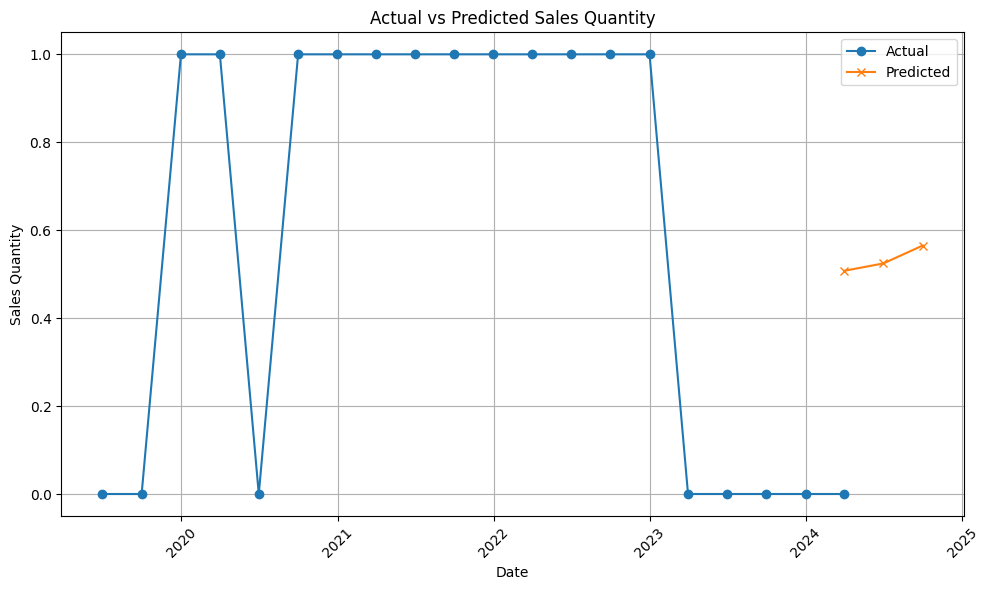

In [191]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from keras.optimizers import RMSprop

# Set random seed for reproducibility
np.random.seed(42)

# Convert merged_df to a numpy array
data = quarterly_df['Quantity'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Function to create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Define sequence length
seq_length = 3

# Create sequences
X, y = create_sequences(scaled_data, seq_length)

# Reshape input data to be 3D for LSTM [samples, timesteps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Build the LSTM model with more layers and RMSprop optimizer
model = Sequential()
model.add(LSTM(200, return_sequences=True, input_shape=(seq_length, 1)))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1, activation='sigmoid'))
optimizer = RMSprop(lr=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model
model.fit(X, y, epochs=50, batch_size=10, verbose=1)

# Make predictions for the next 3 quarters
next_5_months = pd.date_range(quarterly_df['Date'].iloc[-1], periods=3, freq='Q')
next_5_months_scaled = scaler.transform(np.zeros((3, 1)))
next_5_months_X = np.reshape(next_5_months_scaled, (1, seq_length, 1))
predictions_scaled = []

for _ in range(3):
    next_prediction_scaled = model.predict(next_5_months_X)
    predictions_scaled.append(next_prediction_scaled)
    next_5_months_X = np.roll(next_5_months_X, -1, axis=1)  # Roll along time axis
    next_5_months_X[0, -1, 0] = next_prediction_scaled  # Update the last element in the sequence

# Inverse transform the scaled predictions
predictions = scaler.inverse_transform(np.array(predictions_scaled).reshape(-1, 1))

# Plot the predictions
plt.figure(figsize=(10, 6))
plt.plot(quarterly_df['Date'], quarterly_df['Quantity'], label='Actual', marker='o')
plt.plot(next_5_months, predictions, label='Predicted', marker='x')
plt.title('Actual vs Predicted Sales Quantity')
plt.xlabel('Date')
plt.ylabel('Sales Quantity')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [192]:
# Open a text file in write mode
with open('sales_predictions2.txt', 'w') as f:
    # Write header information
    f.write("Customer Name: {}\n".format(selected_customer))
    f.write("Product ID: {}\n".format(selected_product))
    f.write("\n")

    # Write quarterly sales data
    f.write("Quarterly Sales Data:\n")
    f.write(quarterly_df.to_string(index=False))
    f.write("\n\n")

    # Write predicted quantities
    f.write("Predicted Quantities for the Next 3 Quarters:\n")
    for i in range(len(next_5_months)):
        f.write("{}: {}\n".format(next_5_months[i].strftime('%Y-%m-%d'), predictions[i][0]))

# Print confirmation message
print("Data saved successfully.")


Data saved successfully.
